# Demonstrating new Designer API

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

In [47]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions[2:],
    cache = True
)

Random molecule from Enamine REAL.

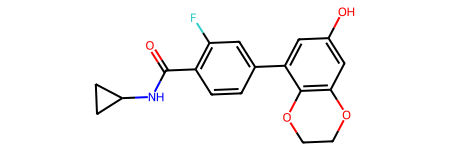

CPU times: user 140 ms, sys: 6.63 ms, total: 146 ms
Wall time: 24.5 ms


{'product': 'O=C(NC1CC1)c1ccc(-c2cc(O)cc3c2OCCO3)cc1F',
 'reaction': '79_Stille',
 'reactants': [{'product': 'O=C(NC1CC1)c1ccc(Br)cc1F'},
  {'product': 'Oc1cc(Br)c2c(c1)OCCO2'}]}

In [48]:
%%time
from numpy.random import randint
import sys
designer.reset()
molecule_1 = designer.design(1)[0]
display(molecule_1)
molecule_1.dump()

Multi-step reaction.

[01:24:59] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 4 


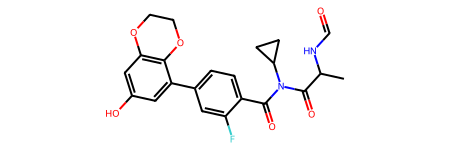

CPU times: user 263 ms, sys: 0 ns, total: 263 ms
Wall time: 45.3 ms


In [49]:
%%time
designer.reset()
molecule_2 = designer.design(molecule_1, size=1, strategy='grow')[0]
display(molecule_2)

Replace reactants in fragment.

CPU times: user 405 ms, sys: 0 ns, total: 405 ms
Wall time: 112 ms


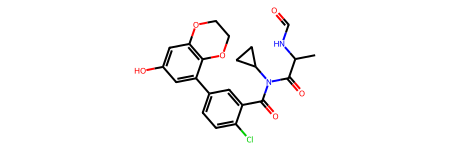

In [50]:
%%time
molecule_3 = designer.design(molecule_2, size=20, strategy='replace', temperature=0.0)[0]
molecule_3

In [51]:
import json

print(json.dumps(molecule_3.dump(), indent=4))

{
    "product": "CC(NC=O)C(=O)N(C(=O)c1cc(-c2cc(O)cc3c2OCCO3)ccc1Cl)C1CC1",
    "reaction": "23_Ester_and_Amine",
    "reactants": [
        {
            "product": "O=C(NC1CC1)c1cc(-c2cc(O)cc3c2OCCO3)ccc1Cl",
            "reaction": "79_Stille",
            "reactants": [
                {
                    "product": "O=C(NC1CC1)c1cc(Br)ccc1Cl"
                },
                {
                    "product": "Oc1cc(Br)c2c(c1)OCCO2"
                }
            ]
        },
        {
            "product": "CC1NC(=O)COC1=O"
        }
    ]
}
